### Import modules

In [105]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

# import auxiliar functions
%autoreload 2
from Auxiliary import *

### Input variables

In [236]:
''' Silicon 111 crystal '''
# dafault crystal parameters
d_sp = 3.13557135638            # reflecting plane d-spacing [A]
psi0r = -5.11321939903e-05      # real part of 0th Fourier component of crystal polarizability
psi0i = 3.58887560736e-06       # imaginary part of ""
psi_hr = -2.71341902391e-05     # real part of Hth Fourier component
psi_hi = 2.50565837652e-06      # imaginary part of ""
psi_hbr = -2.71341902391e-05    # real part of -Hth Fourier coumponent
psi_hbi = 2.50565837652e-06     # imaginary part of ""
tc = 0.01                       # crystal thickness
ang_as = np.deg2rad(5)          # asymmetric angle
uc = 1                          # use case: 1 (Bragg reflection); 2 (Bragg transmission)

ang_dif_pl = 0                  # diffraction plane angle: 0 (vertical); pi/2 (horizontal)
Temp_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

# lens parameters (PMMA)
n = 1 - 5.89e-6         # material refractive index
#d_abs = 788e-6          # material absorption depth
d_abs = 3000e-6
f_lens = 1              # lens focal distance

# aperture parameters
Apt_width = 10e-6      # aperture width (1D)
acentx = 0              # center of aperture [m]
acenty = 0

''' incident beam variables '''
ekev = 10.0                 # photon energy [kev]
pulse_duration = 1.e-15    # pulse duration (rms) [t]
z1 = 200.0                  # distance to first OE [m]
sigX = 30e-6                # w0 (rms) [m]
npoints = 2000              # wavefront sampling dimension
if_load_input = 0           # load (1) or generate (0) incident wavefront

# default values
qnC = 0.1                   # charge [nC]
pulseEnergy = 0.5e-3        # pulse energy [J]
dt = 0.5e-15                # time sampling resolution
if pulse_duration/dt <= 10:
    print('incident beam too short, changing to finer sampling resolution ...')
    dt = 0.1e-15
    if pulse_duration/dt <= 10:
        print(".... okay, the beam is really too short, simulation might break down")
hbar = 6.582119569e-16

# input dimensions
npointsx = 2                # number of points vs horizontal position
npointsy = npoints          # """"""""""""""""""  vertical position

incident beam too short, changing to finer sampling resolution ...


### Calculate sampling parameters

In [237]:
''' calculations '''
wl0 = E2L(ekev*1e3)                 # wavelength
k0 = 2*np.pi/wl0                    # wavenumber
divergence = wl0/np.pi/sigX         # paraxial beam divergence (rms)
range_xy = divergence/2 * z1 * 5    # spatial sampling range (5 sigma)

nvx0, nvy0, nvz0 = Temp_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][2]
thetaB0 = np.arctan(-nvz0/nvy0)+ang_as

trange = calc_stretching(thetaB0, ang_as, range_xy)    # stretched pulse duration
dev = 1/trange * 2*np.pi * hbar     # photon energy sampling resolution
nz = int(trange/dt)                 # number of photon energy slices
if nz % 2!=0:
    nz += 1
pulseRange = trange/pulse_duration

''' diffraction limit and focal spot Rayleigh range '''
thetamax = 2*np.arctan(divergence/2*z1*3/f_lens)
dlim = wl0/2/n/np.sin(thetamax)     # diffraction limit
zR = 1/2 * k0 * dlim**2             # focal spot Rayleigh range

print('beam parameters:\n    {}keV, {}fs, {}um w0, {}urad divergence'.format(
    ekev, round(pulse_duration*1e15,2), round(sigX*1e6,2), round(divergence*1e6,2)))
print('sampling parameters:\n    {}fs dt, {}meV deV, {} nz, {} pulseRange'.format(
    round(dt*1e15,2), round(dev*1e3,2), nz, round(pulseRange,2)))
print('other parameters:\n    Bragg angle {}deg, stretched pulse length {}fs'.format(
    round(np.rad2deg(thetaB0),2),round(trange*1e15,2)))
print('diffraction limit {}um, Rayleigh range {}mm'.format(round(dlim*1e6,2),round(zR*1e3,2)))

beam parameters:
    10.0keV, 1.0fs, 30.0um w0, 1.32urad divergence
sampling parameters:
    0.1fs dt, 6.11meV deV, 6774 nz, 677.4 pulseRange
other parameters:
    Bragg angle 11.42deg, stretched pulse length 677.4fs
diffraction limit 0.08um, Rayleigh range 0.16mm


### Generate incident wavefront

generating incident wavefront
saving incident wavefront
finished in 15.24s
R-space


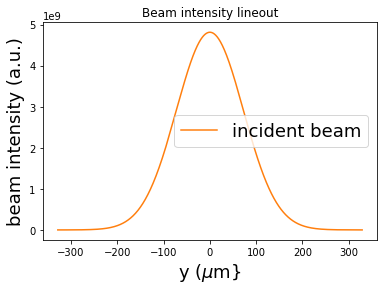

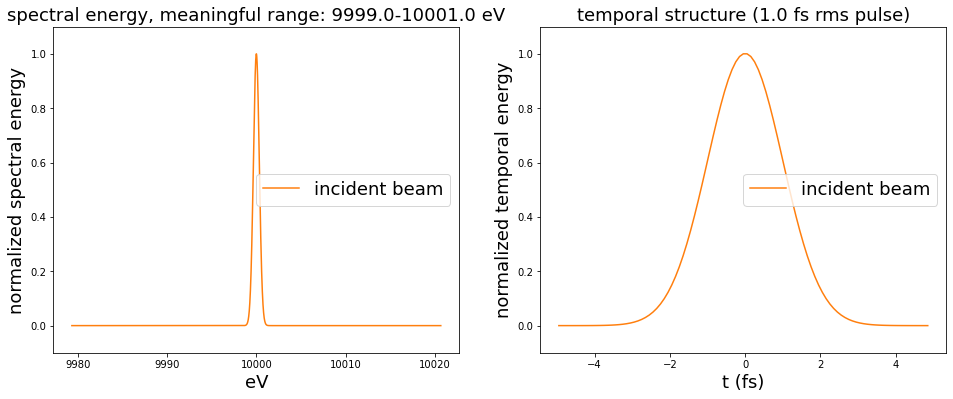

In [238]:
''' directories '''
# output data directory
strDataFolderName = 'WPG_output/Hasan_Mono/' 
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

# sub-folder for current sampling parameters
dirname_duration = strDataFolderName+'{}kev_{}fs_beam_dt={}fs_dev={}meV/'.format(
    ekev,round(pulse_duration*1e15,1),round(dt*1e15,2),round(dev*1e3,2))
if not os.path.exists(dirname_duration):
    mkdir_p(dirname_duration)

# sub-sub-folder for incident beam
dirname_input = dirname_duration+'incident_beam/'
if not os.path.exists(dirname_input):
    mkdir_p(dirname_input)

fname_incident = dirname_input + 'incident_wavefront.h5'

''' load or generate '''
tstart = time.time()
if if_load_input ==1:
    print('loading incident wavefront')
    mwf = Wavefront()
    try:
        mwf.load_hdf5(fname_incident)
    except:
        if_load_input = 0
        print("incident wavefront doesn't exist")

if if_load_input != 1:
    print('generating incident wavefront')
    wfr0 = build_gauss_wavefront(npointsx, npointsy, nz, ekev, -range_xy/2, range_xy/2,
                                    -range_xy/2, range_xy/2 ,pulse_duration, sigX, sigX, z1,
                                    pulseEn=pulseEnergy,pulseRange=pulseRange)

    mwf = Wavefront(wfr0)
    srwl.SetRepresElecField(mwf._srwl_wf, 'f')
    print('saving incident wavefront'.format(round(time.time()-tstart,2)))
    mwf.store_hdf5(fname_incident)
print('finished in {}s'.format(round(time.time()-tstart,2)))

''' plot incident beam structure '''
# spatial profile
if min([npointsx, npointsy])>=4:
    plot_spatial(mwf)
    plt.title('Incident beam', fontsize=18)
else:
    plot_lineout(mwf, 'C1',label='incident beam', if_log=0)
    plt.title('Beam intensity lineout')

# spectra
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
aw, evI, intIs = plot_spectra(mwf,'C1', label='incident beam')
eStart = mwf._srwl_wf.mesh.eStart
eFin = mwf._srwl_wf.mesh.eFin

# temporal profile
plt.subplot(1,2,2)
aw, tI, intIt = plot_temporal(mwf,'C1', label='incident beam', fov=pulse_duration*10, pulse_duration=pulse_duration)


### Define beamline optics

In [239]:
%autoreload 2
from Optics import *
tstart = time.time()

''' beamline crystals '''
ang_as0 = 0                 # asymmetry angle of the first crystal
ang_as1 = np.deg2rad(-5)     # """""""""""""""""""""" second crystal
ang_as2 = 0                 # """""""""""""""""""""" third crystal
ang_as3 = np.deg2rad(5)    # """""""""""""""""""""" 4th crystal

OE_Crystal0 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as0,_uc=uc)
OE_Crystal1 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as1,_uc=uc)
OE_Crystal2 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as2,_uc=uc)
OE_Crystal3 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as3,_uc=uc)

''' crystal orientation '''
set_crystal_orient(OE_Crystal0, ekev*1e3, ang_dif_pl, flip=0)
set_crystal_orient(OE_Crystal1, ekev*1e3, ang_dif_pl, flip=1)
set_crystal_orient(OE_Crystal2, ekev*1e3, ang_dif_pl, flip=1)
set_crystal_orient(OE_Crystal3, ekev*1e3, ang_dif_pl, flip=0)

''' lens calculation '''
Lens_width = range_xy   # lens aperture size
print('calculating OPD and transmission')
Lens_Apt = SRWLOptA('r','a',Lens_width,Lens_width)
Lens_Tr = SRWLOptT(npoints,npoints,Lens_width,Lens_width,_Fx=f_lens,_Fy=f_lens,_x=0,_y=0,_eStart=eStart,_eFin=eFin)

Lens_x = np.linspace(-Lens_width/2,Lens_width/2,npoints)
Lens_x, Lens_y = np.meshgrid(Lens_x,Lens_x)
Lens_z = Perfect_lens(Lens_x,Lens_y,n,f_lens)
Calc_OPD_and_AmpTr(Lens_Tr, Lens_z, n,d_abs)

print('done in {}s'.format(round(time.time()-tstart,2)))

''' aperture '''
OE_Apt = SRWLOptA('r','a',_Dx=range_xy,_Dy=Apt_width,_x=acentx, _y=acenty)


calculating OPD and transmission
done in 8.28s


In [240]:
nvx0, nvy0, nvz0 = OE_Crystal0.find_orient(ekev*1e3,np.pi)[0][2]
tvx0, tvy0, _ = OE_Crystal0.find_orient(ekev*1e3,ang_dif_pl)[0][0]

nvx1, nvy1, nvz1 = OE_Crystal1.find_orient(ekev*1e3,ang_dif_pl)[0][2]
tvx1, tvy1, _ = OE_Crystal1.find_orient(ekev*1e3,ang_dif_pl)[0][0]

nvx2, nvy2, nvz2 = OE_Crystal2.find_orient(ekev*1e3,ang_dif_pl)[0][2]
tvx2, tvy2, _ = OE_Crystal2.find_orient(ekev*1e3,ang_dif_pl)[0][0]

nvx3, nvy3, nvz3 = OE_Crystal3.find_orient(ekev*1e3,ang_dif_pl)[0][2]
tvx3, tvy3, _ = OE_Crystal3.find_orient(ekev*1e3,ang_dif_pl)[0][0]


print(nvx0, nvy0, nvz0, tvx0, tvy0)
print(nvx1, nvy1, nvz1, tvx1, tvy1)
print(nvx2, nvy2, nvz2, tvx2, tvy2)
print(nvx3, nvy3, nvz3, tvx3, tvy3)

np.sin(thetaB0-ang_as0)

-1.200441934240539e-16 -0.9802352278847529 -0.19783553273799567 0 0.19783553273799567
0 0.9592739365769973 -0.28247745857691176 0 0.28247745857691176
0 0.9802352278847529 -0.19783553273799567 0 0.19783553273799567
0 0.9937363231197107 -0.11175025777383232 0 0.11175025777383232


0.19793484164150285

### Define beamline

In [241]:
''' propagation distance '''
z2 = 0.03		# distance between crystal 0 and 1
z3 = f_lens		# distance between crystal 1 and lens 0
z4 = f_lens		# distance between lens 0 and slit
z5 = f_lens		# distance between slit and lens 1
z6 = z3		    # distance between lens 1 and crystal 2
z7 = z2			# distance between crystal 2 and 3
z8 = 1			# distance between crystal 3 and detector

dirname_prop = dirname_duration+'propagation/'
if not os.path.exists(dirname_prop):
    mkdir_p(dirname_prop)

''' propagation parameters '''
#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#              [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11]
ppCrystal0 =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC0 =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppCrystal1 =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC1 =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppLens_Apt =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppLens_Tr =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftL =     [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppApt =        [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftApt =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppCrystal2 =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC2 =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppCrystal3 =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC3 =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

''' beamlines '''
# beam on lens 0 (after 1st pair of crystals)
DriftC0 = SRWLOptD(z2)    # crystal 0 to 1
DriftC1 = SRWLOptD(z3)    # crystal 1 to lens 0
BL0 = SRWLOptC([OE_Crystal0, DriftC0, OE_Crystal1, DriftC1],
               [ppCrystal0, ppDriftC0, ppCrystal1, ppDriftC1])

# beam on slit (after lens 0 on focal plane)
DriftL0 = SRWLOptD(z4)
BL1 = SRWLOptC([Lens_Apt, Lens_Tr, DriftL0], [ppLens_Apt, ppLens_Tr, ppDriftL])

# beam on lens 1 (after slit)
DriftApt = SRWLOptD(z5)
BL2 = SRWLOptC([OE_Apt, DriftApt], [ppApt, ppDriftApt])

# beam on crystal 2 (after lens 1)
DriftL1 = SRWLOptD(z6)       # lens 1 to crystal 2
BL3 = SRWLOptC([Lens_Apt, Lens_Tr, DriftL1], [ppLens_Apt, ppLens_Tr, ppDriftL])

# beam on detector (after 2nd pair of crystals)
DriftC2 = SRWLOptD(z7)    # beam on crystal 3
DriftC3 = SRWLOptD(z8)    # beam on detector
BL4 = SRWLOptC([OE_Crystal2, DriftC2, OE_Crystal3, DriftC3], [ppCrystal2, ppDriftC2, ppCrystal3, ppDriftC3])



### Propagation

In [242]:
''' propagation '''
startTime = time.time()

# to lens 0
print('\n\n*** through 1st pair of crystals, t = {}s'.format(round(time.time()-startTime,2)))
tstamp = time.time()
fname_l0 = dirname_prop + '1_wavefront_on_l0_{}um_slit.h5'.format(round(Apt_width*1e6,2))
mwf_l0 = propagate_wavefront(fname_incident, BL0, fname_l0)

# to slit
print('\n\n*** through lens 0, t = {}s'.format(round(time.time()-tstamp,2)))
tstamp = time.time()
fname_apt = dirname_prop + '2_wavefront_on_slit_{}um_slit.h5'.format(round(Apt_width*1e6,2))
mwf_apt = propagate_wavefront(fname_l0, BL1, fname_apt)

# to lens 1
print('\n\n*** through slit, t = {}s'.format(round(time.time()-tstamp,2)))
tstamp = time.time()
fname_l1 = dirname_prop + '3_wavefront_on_l1_{}um_slit.h5'.format(round(Apt_width*1e6,2))
mwf_l1 = propagate_wavefront(fname_apt, BL2, fname_l1)

# to crystal 2
print('\n\n*** through lens 1, t = {}s'.format(round(time.time()-tstamp,2)))
tstamp = time.time()
fname_c2 = dirname_prop + '4_wavefront_on_c2_{}um_slit.h5'.format(round(Apt_width*1e6,2))
mwf_c2 = propagate_wavefront(fname_l1, BL3, fname_c2)

# to detector
print('\n\n*** through 2nd pair of crystals, t = {}s'.format(round(time.time()-tstamp,2)))
tstamp = time.time()
fname_det = dirname_prop + '5_wavefront_on_det_{}um_slit.h5'.format(round(Apt_width*1e6,2))
mwf_det = propagate_wavefront(fname_c2, BL4, fname_det)

print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))




*** through 1st pair of crystals, t = 0.0s
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = 0
	aux_ang_dif_pl = 0
	aux_energy = 10000.0
	dSp = 3.13557135638
	nvx = 0
	nvy = 0.9802352278847529
	nvz = -0.19783553273799567
	psi0i = 3.58887560736e-06
	psi0r = -5.11321939903e-05
	psiHbi = 2.50565837652e-06
	psiHbr = -2.71341902391e-05
	psiHi = 2.50565837652e-06
	psiHr = -2.71341902391e-05
	tc = 0.01
	tvx = 0
	tvy = 0.19783553273799567
	uc = 1
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 0.03
	treat = 0
	
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = -0.08726646259971647
	aux_ang_dif_pl = 0
	aux_energy = 10000.0
	dSp = 3.13557135638
	nvx = -1.1747717559345008e-16
	nvy = -0.9592739365769973
	nvz = -0.28247745857691176
	psi0i = 3.58887560736e-06
	psi0r = -5.11321939903e-05
	psiHbi = 2.50565837652e-06
	psiHbr = -2.7134190

### Plot results

R-space
R-space
R-space
R-space
R-space
R-space


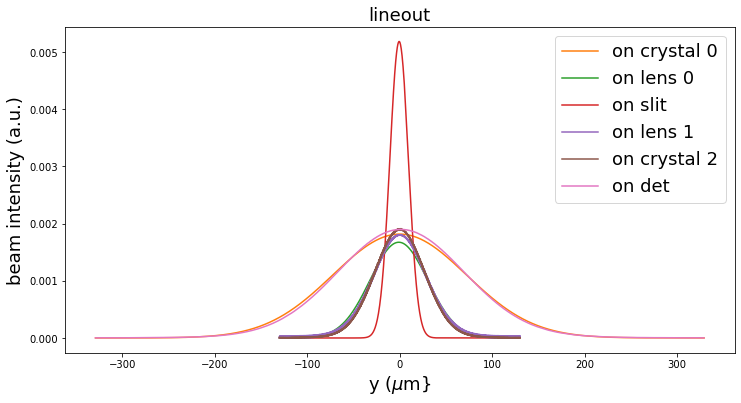

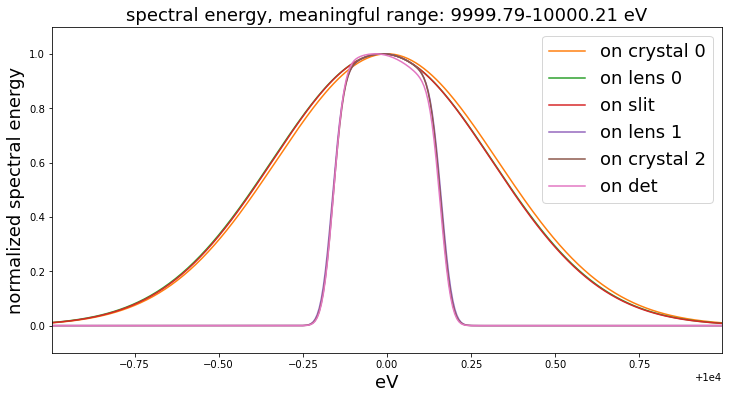

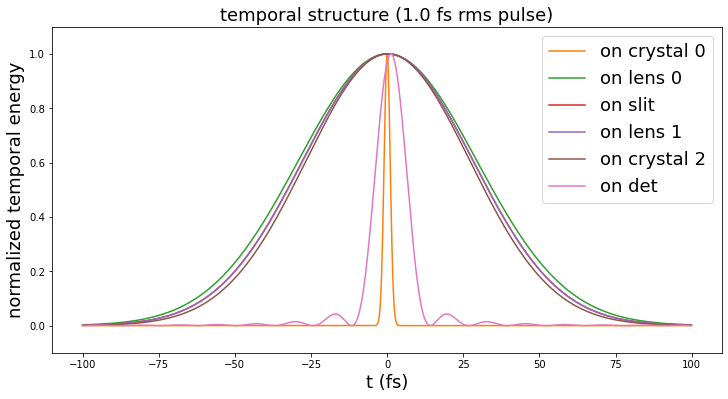

In [243]:
''' lineout everywhere '''
if_log = 0
if_norm = 1
plt.figure(figsize=(12,6))
plot_lineout(mwf, 'C1', label='on crystal 0',if_log=if_log,if_norm=if_norm)
plot_lineout(mwf_l0, 'C2', label='on lens 0',if_log=if_log,if_norm=if_norm)
plot_lineout(mwf_apt, 'C3', label='on slit',if_log=if_log,if_norm=if_norm)
plot_lineout(mwf_l1, 'C4', label='on lens 1',if_log=if_log,if_norm=if_norm)
plot_lineout(mwf_c2, 'C5', label='on crystal 2',if_log=if_log,if_norm=if_norm)
plot_lineout(mwf_det, 'C6', label='on det',if_log=if_log,if_norm=if_norm)
plt.savefig(dirname_prop+'lineout_{}um_slit.png'.format(round(Apt_width*1e6,2)))

''' spectra everywhere '''
plt.figure(figsize=(12,6))
awc0, evc0, intc0s = plot_spectra(mwf, 'C1', label='on crystal 0')
awl0, evl0, intl0s = plot_spectra(mwf_l0, 'C2', label='on lens 0')
awapt, evapt, intapts = plot_spectra(mwf_apt,'C3', label='on slit')
awl1, evl1, intl1s = plot_spectra(mwf_l1, 'C4', label='on lens 1')
awc2, evc2, intc2s = plot_spectra(mwf_c2, 'C5', label='on crystal 2')
awdet, evdet, intdets = plot_spectra(mwf_det,'C6', label='on det')
plt.xlim([evc0[awc0.min()],evc0[awc0.max()]])
plt.savefig(dirname_prop+'spectra.png_{}um_slit.png'.format(round(Apt_width*1e6,2)))

''' temporal profilfe everywhere '''
fov = 200e-15
plt.figure(figsize=(12,6))
awc0, tc0, intc0t = plot_temporal(mwf, 'C1', label='on crystal 0',fov=fov, pulse_duration = pulse_duration)
awl0, tl0, intl0t = plot_temporal(mwf_l0, 'C2', label='on lens 0',fov=fov, pulse_duration = pulse_duration)
awapt, tapt, intaptt = plot_temporal(mwf_apt,'C3', label='on slit',fov=fov, pulse_duration = pulse_duration)
awl1, tl1, intl1t = plot_temporal(mwf_l1, 'C4', label='on lens 1',fov=fov, pulse_duration = pulse_duration)
awc2, tc2, intc2t = plot_temporal(mwf_c2, 'C5', label='on crystal 2',fov=fov, pulse_duration = pulse_duration)
awdet, tdet, intdett = plot_temporal(mwf_det,'C6', label='on det',fov=fov, pulse_duration = pulse_duration)

plt.savefig(dirname_prop+'temporal profile_{}um_slit.png'.format(round(Apt_width*1e6,2)))

R-space
R-space
R-space
R-space
R-space
R-space


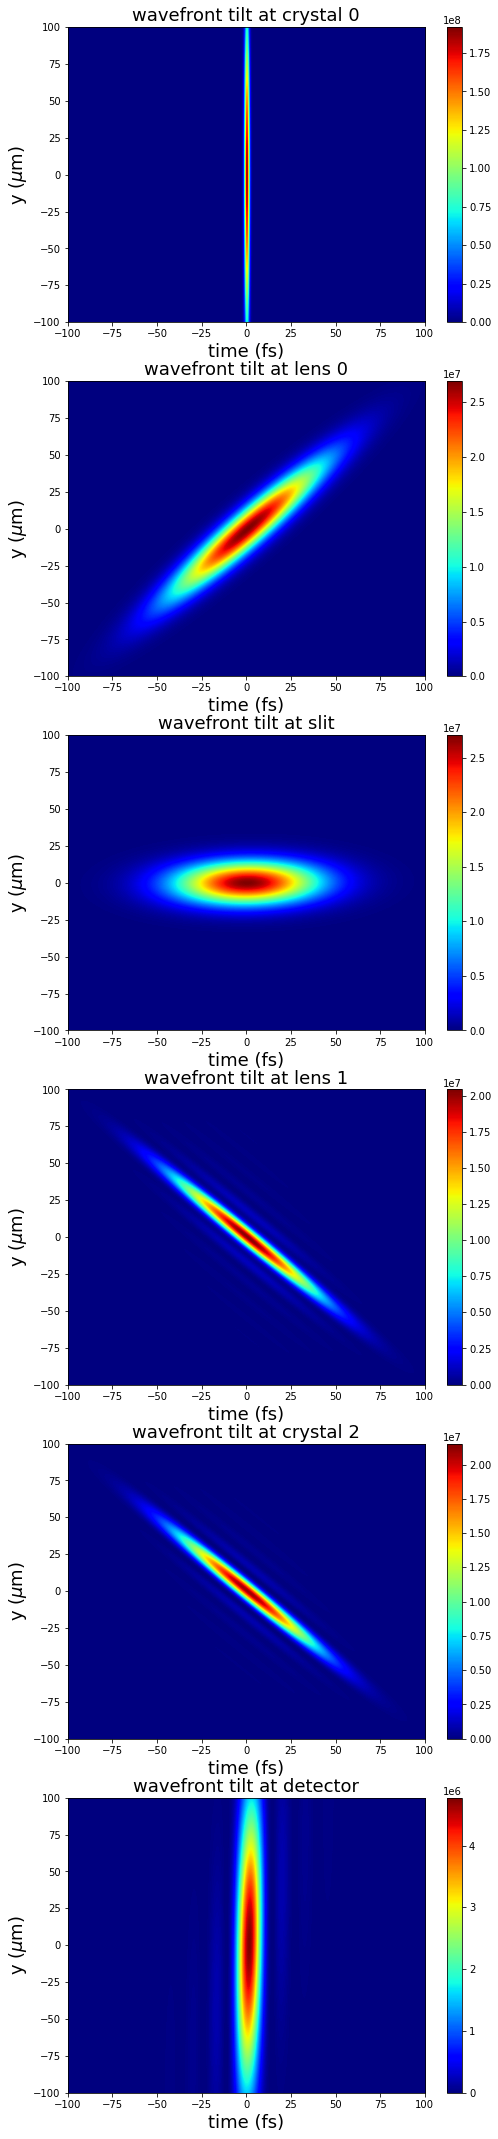

In [244]:
''' wavefront profile everywhere '''
ori = 'V'
fov_y = 200    # um
fov_t = 200    # fs
plt.figure(figsize=(8,38))
plt.subplot(6,1,1)
plot_tilt(mwf, 'C1', label='crystal 0',ori=ori)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.subplot(6,1,2)
plot_tilt(mwf_l0, 'C2', label='lens 0',ori=ori)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.subplot(6,1,3)
plot_tilt(mwf_apt, 'C3', label='slit',ori=ori)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.subplot(6,1,4)
plot_tilt(mwf_l1, 'C4', label='lens 1',ori=ori)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.subplot(6,1,5)
plot_tilt(mwf_c2, 'C5', label='crystal 2',ori=ori)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.subplot(6,1,6)
plot_tilt(mwf_det, 'C6', label='detector',ori=ori)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.savefig(dirname_prop+'wavefront_tilt_{}um_slit.png'.format(round(Apt_width*1e6,2)))

In [245]:
# plot log scale of the previous plot

# if beam too small in time slice, can change focal distance to smaller so that the beam doesn't break down before reaches the next OE.
    # Fresnel distance

# focal length 1m, plot wavefront tilt at 0.1m before and after focal plane.
    # Then compare what the focal plane looks like when focal length is reduced.
    # also since the beam is rotating, check what beam looks like when it's "flat" in yz.



In [246]:
# for tmr's meeting, talk about what I was working on/ have learnt in the past ~6 wks.
    # crystal
    # SRW sampling parameters
    # use Hasan's mono as a project to understand SRW.
    # plot Hasan's setup schematics and label the distance
    # show that monochromatic can be adjusted, but what problems I ran into for broadband

# summarize what can be calculated now.
    # <= 10 slides.
    # plot 10 and 20fs see how tilt at focal plane limits performance
    # the other limitation comes from diffraction limit (basically how small the beam is in y limits performace)
    
# plots to make:
    # log scale
    # 50fs, 10fs, 1fs, .1fs
        # show what's not working in 1/0.1fs and explain what's puzzling me
    # show slit 1mm, 10um, 5um, 1um for 50fs case
    # show slit ** for 1fs case
    


In [247]:
# higher resolution
# 1. smaller focus:
    # shorter focal length
    # if slit width smaller than a few micron, then it's not worth it
    
# 2. increase dispersion
    # calculate the maximum dispersion value
    # Si 111 doesn't have high enough resolution (too broad, not dispersive enough)
    
# 3. 

# Doubts
### 1. weird shape on temporal crystal 2 and 3

This is due to the beam being too big on lens and not sampling enough range.

In [248]:
# want fully compensated, pulse duration goes back to before focusing/reflecting

# once that part works, close down the slit gradually and see if bandwidth narrows + Fourier limit.

# calculate the beam pathlength as a function of y (or at the boundary)

# plot the spectral space (y-lineout vs incident photon energy) or temporal space (y-lineout vs slices around focal plane)

# see if I can reproduce Haoyuan's paper (6 cc)

# basically wants to check the temporal impact and see if systems maintain beam properties
